<a href="https://colab.research.google.com/github/andresenrique08/ML_2020/blob/master/Reto%203/Reto3_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reto 3.0

### Curso de Machine Learning 2020-20
Autores:
*    Andrés Enrique Ávila Rojas (201319127)
*   Jeison Alexander Timana Rangel (201617870)

In [1]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modulos para contingencias
from scipy.stats import chi2
from scipy.stats import chi2_contingency

# Modulos de scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix

Se toman los datos del repositorio de github con el siguiente link https://raw.githubusercontent.com/andresenrique08/ML_2020/master/Reto%203/msd_genre_dataset.txt

In [2]:
# Reading file from github
url = "https://raw.githubusercontent.com/andresenrique08/ML_2020/master/Reto%203/msd_genre_dataset.txt"
data  = pd.read_csv(url,skiprows=9, sep=",") 
data.head()

,%genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
0,classic pop and rock,TRFCOOU128F427AEC0,Blue Oyster Cult,Mes Dames Sarat,-8.697,155.007,1,9,1,246.33424,46.673067,14.613684,14.664215,0.176561,-9.346377,-12.341699,11.183382,7.405288,9.313765,3.201169,-0.152734,5.809709,14.930820,802.205948,1255.514569,580.030472,598.485223,575.337671,322.068603,321.726029,232.700609,186.805303,181.938688,151.508011
1,classic pop and rock,TRNJTPB128F427AE9F,Blue Oyster Cult,Screams,-10.659,148.462,1,4,0,189.80526,43.645377,-87.337150,41.051582,7.814770,-12.989848,-14.253599,6.126045,-2.448662,22.691713,-2.872706,1.427725,-6.710730,22.704843,1561.307072,2007.653070,1043.474073,585.694981,564.013736,510.177022,400.200186,365.119588,238.099708,197.933757,251.577525
2,classic pop and rock,TRLFJHA128F427AEEA,Blue Oyster Cult,Dance The Night Away,-13.494,112.909,1,10,0,158.19710,37.573538,-61.202030,28.760533,-13.788123,10.062347,-4.872030,-14.090243,5.580175,15.414011,4.556137,-1.877363,20.879475,58.459621,4644.001846,1204.856777,2736.520024,730.233239,665.203452,535.775111,439.335059,486.822970,265.333860,447.097987,251.880724
3,classic pop and rock,TRCQZAG128F427DB97,Blue Oyster Cult,Debbie Denise,-12.786,117.429,4,7,1,250.22649,42.566615,17.217897,53.484213,1.564362,-8.884632,-13.088890,-9.762620,1.373769,1.092876,1.479490,1.517015,8.562618,22.575460,691.140671,809.755802,563.908070,492.803819,378.382799,372.875044,231.941957,246.313305,168.400152,85.282462,339.897173
4,classic pop and rock,TRNXMNM128F427DB8C,Blue Oyster Cult,(Don't Fear) The Reaper,-14.093,141.536,4,9,0,307.06893,40.976507,-13.609779,39.566169,-5.602033,-17.754819,-21.833261,-5.600732,2.291770,3.526177,1.535449,2.763958,3.388757,34.294994,1062.180815,1093.684935,343.556047,889.163314,218.111796,304.862864,178.352161,440.478867,142.669283,81.061326,208.355152


Los géneros presentes en la base de datos son los siguientes:

In [3]:
generos = data['%genre'].unique()
generos = pd.DataFrame(data=generos, columns=['Generos'])
generos

,Generos
0,classic pop and rock
1,punk
2,folk
3,pop
4,dance and electronica
5,metal
6,jazz and blues
7,classical
8,hip-hop
9,soul and reggae


## Preparación de los datos

Teniendo en cuenta que se espera resolver el problema de clasificación binaria (usando ```scikit-learn```) entre los géneros jazz and blues y soul and reggae, se procede a crear un dataframe con solo la información correspondiente a estos dos géneros.



In [4]:
data_bin = data[data['%genre'].isin(['jazz and blues','soul and reggae'])]
data_bin.head()

,%genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
48942,jazz and blues,TRJBLUX12903CE16EC,John Stevens,Mango,-18.996,89.147,1,0,1,256.86159,34.738162,-50.948828,20.177101,15.139567,-25.836751,7.729854,-23.534951,-7.002408,9.661461,-0.752980,6.760097,17.112598,12.473302,1530.622764,1649.321047,1221.638146,501.717892,1091.743641,618.560018,402.236969,309.392602,233.206167,261.850703,240.834177
48943,jazz and blues,TRDPDLX12903CE16F2,John Stevens,Carnaval,-19.347,125.825,4,2,1,301.87057,34.033346,-39.733083,30.640298,19.646264,-45.231415,9.103613,-19.019581,1.119047,9.169450,3.999394,5.481075,10.958845,11.150600,1385.186042,1670.689893,1339.193474,889.918742,1148.824912,428.976969,306.187624,368.973940,227.275123,261.643570,332.356536
48944,jazz and blues,TRMWVBM128F42374DA,John Stevens,My Blue Heaven (Album Version),-9.472,121.707,4,2,1,158.85016,41.794197,-22.133118,3.518487,1.868059,13.542078,6.944006,15.406498,5.469637,4.822017,1.792601,-10.094489,-2.143374,41.497045,4513.995103,2640.398239,3070.791615,1347.758671,1499.491510,1015.076345,897.411739,608.034880,549.493210,481.149049,442.663136
48945,jazz and blues,TRMLIWL128F42374DE,John Stevens,Here_ There And Everywhere (Album Version),-14.406,83.012,5,0,1,181.26322,38.637530,-64.807191,-21.920418,-25.058971,-2.520459,-11.979187,-4.021518,-4.502840,1.350948,-6.206154,-2.557249,1.841054,26.279428,2304.536939,1187.644248,1311.170435,809.621938,612.699944,492.734025,525.801667,585.984445,278.578591,250.545027,348.842236
48946,jazz and blues,TRGFUVB128F42374E1,John Stevens,This Love (Album Version),-9.289,76.013,4,7,0,248.89424,43.089845,-27.351674,14.205832,-6.941388,21.278516,-9.627968,-6.894824,-2.730303,2.003291,-2.030266,-0.764775,1.769443,37.786419,3726.684916,1164.272074,1536.674490,1167.316436,580.604008,498.168561,607.747214,367.191519,403.532772,262.670577,272.634634


Para asegurarnos que solo estén los generos que se usarán para el análisis, se verifica que solo estos géneros esten en nuestro nuevo dataframe



In [5]:
generos = data_bin['%genre'].unique()
generos = pd.DataFrame(data=generos, columns=['Generos'])
generos

,Generos
0,jazz and blues
1,soul and reggae


Ahora comparamos cuantos datos de cada género hay en nuestro dataframe, obteniendo el siguiente histograma

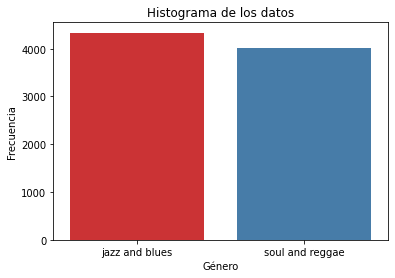

jazz and blues     0.519042
soul and reggae    0.480958
Name: %genre, dtype: float64

In [6]:
f = plt.figure()
sns.countplot(x="%genre", data=data_bin, palette="Set1")
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.title('Histograma de los datos')
plt.show()
data_bin['%genre'].value_counts()/len(data_bin)

En esta oportunidad no se tendrá en cuenta la columna correspondiente a ```artist_name``` debido a que este dato puede generar un error en el modelamiento del clasificador afectando los resultados de predicción, considerando que esta variable provee información adicional que facilita su clasificación. Con esto en mente, se obtiene la siguiente información.


In [7]:
data_bin = data_bin.drop(['artist_name'],axis=1)
data_bin.head()

,%genre,track_id,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
48942,jazz and blues,TRJBLUX12903CE16EC,Mango,-18.996,89.147,1,0,1,256.86159,34.738162,-50.948828,20.177101,15.139567,-25.836751,7.729854,-23.534951,-7.002408,9.661461,-0.752980,6.760097,17.112598,12.473302,1530.622764,1649.321047,1221.638146,501.717892,1091.743641,618.560018,402.236969,309.392602,233.206167,261.850703,240.834177
48943,jazz and blues,TRDPDLX12903CE16F2,Carnaval,-19.347,125.825,4,2,1,301.87057,34.033346,-39.733083,30.640298,19.646264,-45.231415,9.103613,-19.019581,1.119047,9.169450,3.999394,5.481075,10.958845,11.150600,1385.186042,1670.689893,1339.193474,889.918742,1148.824912,428.976969,306.187624,368.973940,227.275123,261.643570,332.356536
48944,jazz and blues,TRMWVBM128F42374DA,My Blue Heaven (Album Version),-9.472,121.707,4,2,1,158.85016,41.794197,-22.133118,3.518487,1.868059,13.542078,6.944006,15.406498,5.469637,4.822017,1.792601,-10.094489,-2.143374,41.497045,4513.995103,2640.398239,3070.791615,1347.758671,1499.491510,1015.076345,897.411739,608.034880,549.493210,481.149049,442.663136
48945,jazz and blues,TRMLIWL128F42374DE,Here_ There And Everywhere (Album Version),-14.406,83.012,5,0,1,181.26322,38.637530,-64.807191,-21.920418,-25.058971,-2.520459,-11.979187,-4.021518,-4.502840,1.350948,-6.206154,-2.557249,1.841054,26.279428,2304.536939,1187.644248,1311.170435,809.621938,612.699944,492.734025,525.801667,585.984445,278.578591,250.545027,348.842236
48946,jazz and blues,TRGFUVB128F42374E1,This Love (Album Version),-9.289,76.013,4,7,0,248.89424,43.089845,-27.351674,14.205832,-6.941388,21.278516,-9.627968,-6.894824,-2.730303,2.003291,-2.030266,-0.764775,1.769443,37.786419,3726.684916,1164.272074,1536.674490,1167.316436,580.604008,498.168561,607.747214,367.191519,403.532772,262.670577,272.634634


Continuando con el pre procesamiento de los datos, pasaremos a verificar los datos nulos dentro del dataframe

In [8]:
missing_values_count = data_bin.isnull().sum()
total_missing = missing_values_count.sum()
print('Hay {} datos perdidos en el dataframe'.format(total_missing))

Hay 0 datos perdidos en el dataframe


Se observa que no hay datos perdidos. Ahora, se procede a verificar si hay filas duplicadas.


In [9]:
print('Hay {} filas duplicadas en el dataframe'.format(data_bin.duplicated().sum()))

Hay 0 filas duplicadas en el dataframe


Una vez observado que no hay filas duplicadas ni datos perdidos, se procede a verificar el tipo de las variables del dataframe.

In [10]:
data_bin.dtypes

%genre             object
track_id           object
title              object
loudness          float64
tempo             float64
time_signature      int64
key                 int64
mode                int64
duration          float64
avg_timbre1       float64
avg_timbre2       float64
avg_timbre3       float64
avg_timbre4       float64
avg_timbre5       float64
avg_timbre6       float64
avg_timbre7       float64
avg_timbre8       float64
avg_timbre9       float64
avg_timbre10      float64
avg_timbre11      float64
avg_timbre12      float64
var_timbre1       float64
var_timbre2       float64
var_timbre3       float64
var_timbre4       float64
var_timbre5       float64
var_timbre6       float64
var_timbre7       float64
var_timbre8       float64
var_timbre9       float64
var_timbre10      float64
var_timbre11      float64
var_timbre12      float64
dtype: object

Se puede observar que hay 3 variables categoricas y todas las demás son númericas. Una de las variables categoricas corresponde a la variable ```%genre```, la cual es nuestra variable objetivo por lo tanto es necesario ver el comportamiento de las otras variables para conocer si pueden o no influir el modelo de clasificación. Para ello procederemos a verficar el total de valores únicos y compararlos con la longitud total de los datos del dataframe, de la siguiente forma.

In [11]:
total_data = len(data_bin)
tot_track_id = len(data_bin.track_id.unique())
tot_title= len(data_bin.title.unique())

if total_data == tot_track_id:
  print('Los valores únicos de la variable track_id son iguales al total de datos, por lo que no aportan información relevante. \n')
else:
  print('La variable track_id puede aportar información útil para el análisis y se debe revisar en detalle. \n')

if total_data == tot_title:
  print('Los valores únicos de la variable title son iguales al total de datos, por lo que no aportan información relevante.')
else:
  print('La variable title puede aportar información útil para el análisis y se debe revisar en detalle.')


Los valores únicos de la variable track_id son iguales al total de datos, por lo que no aportan información relevante. 

La variable title puede aportar información útil para el análisis y se debe revisar en detalle.


Se observa que la variable ```track_id``` puede ser eliminada del modelo, puesto que no aporta información relavante para la clasificación y hay un track_id diferente para cada fila. Por su parte la variable ```title``` no contiene un valor diferente por cada fila, lo que muestra que algunos de los títulos de las canciones se repiten, esto puede deberse a que diferentes autores nombraron de igual forma algunas canciones o debido a otros factores. Para comprobar que la variable objetivo ```%genre``` no tenga dependencia de esta variable, se realiza un análisis de contingencia con chi-cuadrado como se muestra a continuación.

In [12]:
Tabla_c = pd.crosstab(index=data_bin['%genre'],columns=data_bin["title"],margins=True)
chi2_contingency(Tabla_c)

(8183.224779508331,
 1.0,
 14690,
 array([[5.19041916e-01, 5.19041916e-01, 5.19041916e-01, ...,
         5.19041916e-01, 5.19041916e-01, 4.33400000e+03],
        [4.80958084e-01, 4.80958084e-01, 4.80958084e-01, ...,
         4.80958084e-01, 4.80958084e-01, 4.01600000e+03],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 8.35000000e+03]]))

In [13]:
# Guardo el p-value en una variable para luego evaluarla dado las condiciones de abajo
pvalue = chi2_contingency(Tabla_c)[1]
# Usando prints y if para saber si acepto o no la hipotesis nula y 
# asi concentrarme en el analisis 
print("Hipotesis NULA:", "Las variables son independendientes")
print("P-Value:", pvalue)

pval = pvalue
# nivel de significancia 0.001
if pval > 0.001:
    print("Accept NULL hypothesis - Las variables son independientes es decir que no tienen relación entre ellas.")
if pval <= 0.001:
    print("Reject NULL hypothesis - Las variables son dependientes.")

Hipotesis NULA: Las variables son independendientes
P-Value: 1.0
Accept NULL hypothesis - Las variables son independientes es decir que no tienen relación entre ellas.


Los resultados muestran bajo un nivel de significancia del 0.001% que las variables no tienen dependencia entre ellas. Por lo que la variable ```title``` podría ser eliminada del modelo. De esta forma se obtiene el siguiente conjunto de datos para la implementación del modelo.

In [14]:
data_bin = data_bin.drop(['track_id','title'], axis=1)
data_bin.head()

,%genre,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
48942,jazz and blues,-18.996,89.147,1,0,1,256.86159,34.738162,-50.948828,20.177101,15.139567,-25.836751,7.729854,-23.534951,-7.002408,9.661461,-0.752980,6.760097,17.112598,12.473302,1530.622764,1649.321047,1221.638146,501.717892,1091.743641,618.560018,402.236969,309.392602,233.206167,261.850703,240.834177
48943,jazz and blues,-19.347,125.825,4,2,1,301.87057,34.033346,-39.733083,30.640298,19.646264,-45.231415,9.103613,-19.019581,1.119047,9.169450,3.999394,5.481075,10.958845,11.150600,1385.186042,1670.689893,1339.193474,889.918742,1148.824912,428.976969,306.187624,368.973940,227.275123,261.643570,332.356536
48944,jazz and blues,-9.472,121.707,4,2,1,158.85016,41.794197,-22.133118,3.518487,1.868059,13.542078,6.944006,15.406498,5.469637,4.822017,1.792601,-10.094489,-2.143374,41.497045,4513.995103,2640.398239,3070.791615,1347.758671,1499.491510,1015.076345,897.411739,608.034880,549.493210,481.149049,442.663136
48945,jazz and blues,-14.406,83.012,5,0,1,181.26322,38.637530,-64.807191,-21.920418,-25.058971,-2.520459,-11.979187,-4.021518,-4.502840,1.350948,-6.206154,-2.557249,1.841054,26.279428,2304.536939,1187.644248,1311.170435,809.621938,612.699944,492.734025,525.801667,585.984445,278.578591,250.545027,348.842236
48946,jazz and blues,-9.289,76.013,4,7,0,248.89424,43.089845,-27.351674,14.205832,-6.941388,21.278516,-9.627968,-6.894824,-2.730303,2.003291,-2.030266,-0.764775,1.769443,37.786419,3726.684916,1164.272074,1536.674490,1167.316436,580.604008,498.168561,607.747214,367.191519,403.532772,262.670577,272.634634


De esta manera observamos que la única variable categorica dentro del dataframe es la variable objetivo. Como sabemos esta variable es binaria, por lo que se reemplazará los valores categoricos de la siguiente manera:


*   ```jazz and blues``` = 0
*   ```soul and reggae``` = 1

Obteniendo finalmente el siguiente dataframe.

In [15]:
data_bin['%genre'].replace(['jazz and blues','soul and reggae'],[0,1], inplace=True)
data_bin.head()

,%genre,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
48942,0,-18.996,89.147,1,0,1,256.86159,34.738162,-50.948828,20.177101,15.139567,-25.836751,7.729854,-23.534951,-7.002408,9.661461,-0.752980,6.760097,17.112598,12.473302,1530.622764,1649.321047,1221.638146,501.717892,1091.743641,618.560018,402.236969,309.392602,233.206167,261.850703,240.834177
48943,0,-19.347,125.825,4,2,1,301.87057,34.033346,-39.733083,30.640298,19.646264,-45.231415,9.103613,-19.019581,1.119047,9.169450,3.999394,5.481075,10.958845,11.150600,1385.186042,1670.689893,1339.193474,889.918742,1148.824912,428.976969,306.187624,368.973940,227.275123,261.643570,332.356536
48944,0,-9.472,121.707,4,2,1,158.85016,41.794197,-22.133118,3.518487,1.868059,13.542078,6.944006,15.406498,5.469637,4.822017,1.792601,-10.094489,-2.143374,41.497045,4513.995103,2640.398239,3070.791615,1347.758671,1499.491510,1015.076345,897.411739,608.034880,549.493210,481.149049,442.663136
48945,0,-14.406,83.012,5,0,1,181.26322,38.637530,-64.807191,-21.920418,-25.058971,-2.520459,-11.979187,-4.021518,-4.502840,1.350948,-6.206154,-2.557249,1.841054,26.279428,2304.536939,1187.644248,1311.170435,809.621938,612.699944,492.734025,525.801667,585.984445,278.578591,250.545027,348.842236
48946,0,-9.289,76.013,4,7,0,248.89424,43.089845,-27.351674,14.205832,-6.941388,21.278516,-9.627968,-6.894824,-2.730303,2.003291,-2.030266,-0.764775,1.769443,37.786419,3726.684916,1164.272074,1536.674490,1167.316436,580.604008,498.168561,607.747214,367.191519,403.532772,262.670577,272.634634


Adicionalmente, siguiendo las recomendaciones de la página oficinal de los <a href="https://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips">modelos de redes neuronales (supervisado)</a> de Scikit-Learn, se realiza la estandarización del conjunto de datos mediante el método MinMaxScaler que estandariza los datos $x$ de la siguiente forma, teniendo en cuenta los datos de la columna de la variable $v$:

$ z=\frac{x-\min(x)}{\max(x)-\min(x)}[(\max(v)-\min(v))+\min(x)]$

Donde $v$ pertenece al conjunto total de $x$ y $x$ pasa por un $v$ especifico, es decir por cada variable representada por una columna. De esta manera se obtiene la siguiente muestra de los datos.


In [16]:
scaler = MinMaxScaler()
data_bin = pd.DataFrame(scaler.fit_transform(data_bin), columns=data_bin.columns)
data_bin['%genre'] = data_bin['%genre'].astype(int)
data_bin.head()

,%genre,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
0,0,0.540775,0.353277,0.142857,0.000000,1.0,0.088999,0.575350,0.318832,0.442692,0.549958,0.363029,0.385309,0.360767,0.462401,0.669684,0.419899,0.797934,0.666495,0.038407,0.047278,0.076034,0.079438,0.068968,0.128698,0.099308,0.077007,0.097205,0.095678,0.106249,0.086422
1,0,0.532164,0.498627,0.571429,0.181818,1.0,0.104668,0.560022,0.337049,0.466187,0.572080,0.281699,0.394378,0.389008,0.527240,0.666231,0.490502,0.778664,0.610157,0.033756,0.041603,0.077229,0.088441,0.135484,0.136040,0.061473,0.052752,0.119388,0.092242,0.106146,0.124834
2,0,0.774436,0.482308,0.571429,0.181818,1.0,0.054880,0.728804,0.365637,0.405286,0.484811,0.528162,0.380122,0.604321,0.561974,0.635719,0.457717,0.544002,0.490205,0.140484,0.163703,0.131462,0.221055,0.213932,0.181143,0.178442,0.202052,0.208392,0.278903,0.215859,0.171129
3,0,0.653386,0.328965,0.714286,0.000000,1.0,0.062682,0.660153,0.296322,0.348165,0.352631,0.460805,0.255204,0.482811,0.482357,0.611359,0.338884,0.657558,0.526683,0.086964,0.077480,0.050214,0.086295,0.121725,0.067083,0.074197,0.108210,0.200183,0.121962,0.100599,0.131753
4,0,0.778925,0.301229,0.571429,0.636364,0.0,0.086226,0.756982,0.357160,0.429284,0.441567,0.560604,0.270725,0.464840,0.496508,0.615937,0.400923,0.684564,0.526027,0.127434,0.132979,0.048907,0.103565,0.183014,0.062955,0.075282,0.128904,0.118724,0.194348,0.106659,0.099769


Ahora, con el fin de validar las correlaciones entre las variables se presentan los siguientes mapas de calor de las correlaciones de pearson y spearman.

Text(0.5, 0.91, 'Mapa de calor para las correlaciones de los datos')

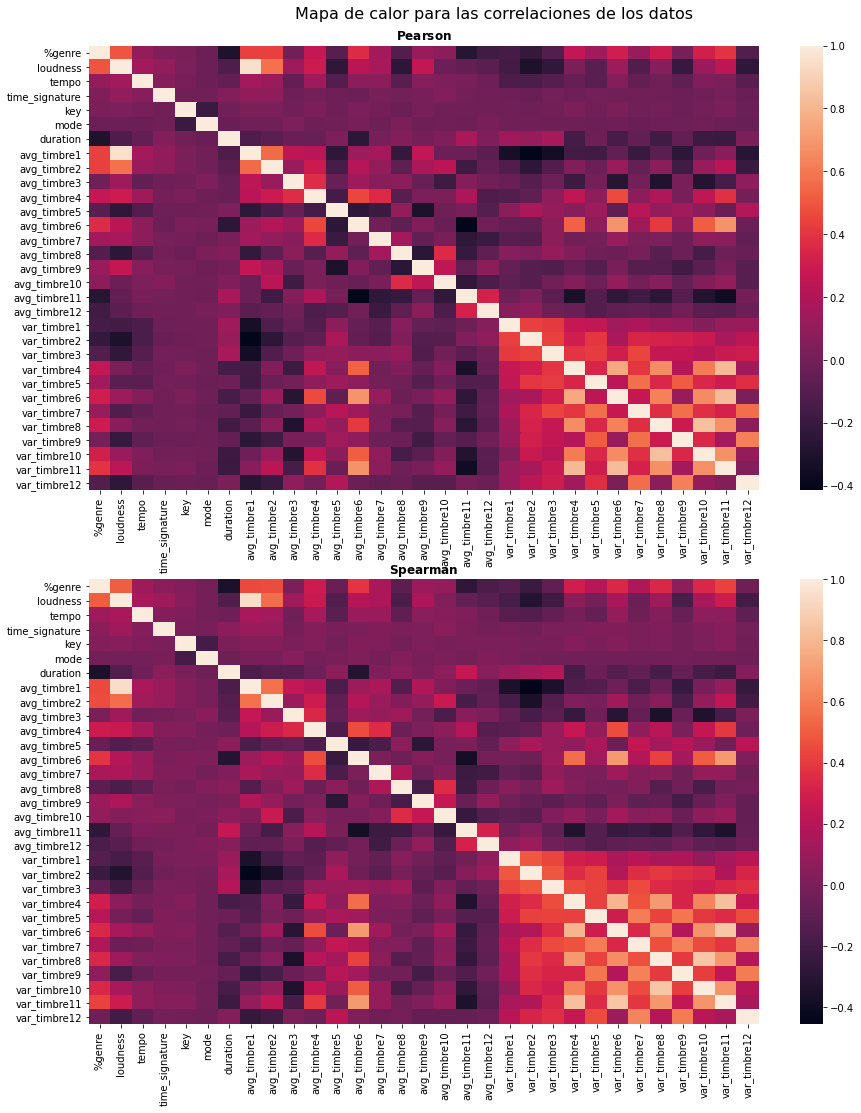

In [17]:
fig = plt.figure(figsize =(15,18))
plt.subplot(2,1,1)
sns.heatmap(data_bin.corr(method ='pearson'))
plt.title(r'$\bf{Pearson}$')
plt.subplot(2,1,2)
sns.heatmap(data_bin.corr(method ='spearman'))
plt.title(r'$\bf{Spearman}$')
fig.suptitle('Mapa de calor para las correlaciones de los datos', y=0.91, fontsize=16)

Se puede observar que la mayoría de variable tiene una correlación por encima de 0.5 con la variable objetivo y que las variables que no tienen una correlación significativa con la variable objetivo, tienen relación con otras variables por lo que se posdría considerar que todas las variables terminarán teniendo algún grado de influencia en el resultado de clasificación final. Por ello se decide dejar la base de datos que está hasta este punto.

### Selección del conjunto de entrenamiento y de prueba

En este punto se selecciona el conjunto de datos de entrenamiento y de prueba para el modelo de clasificación que se realizará. En esta ocasión se usa la función ```train_test_split```, donde se define que el 20% de los datos totales disponibles para el análisis son destinados para el conjunto de evaluación o validación del modelo, lo que implica que este conjunto tendrá un total de 1670 datos; mientras que el conjunto de entrenamiento tendrá el resto de datos, es decir 6680 datos. Este proceso es presentado a continuación:

In [18]:
Y = data_bin['%genre']
X = data_bin.drop(['%genre'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

Con el fin de observar el total de datos de cada género que están siendo usados para cada conjunto se presentan los siguientes histogramas.

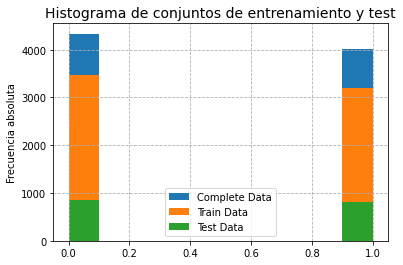

jazz and blues: 0 
soul and reggae: 1


In [19]:
fig = plt.figure()
data_bin['%genre'].hist(label='Complete Data')
y_train.hist(label='Train Data')
y_test.hist(label='Test Data')
plt.legend()
plt.grid(linestyle='--',b=True, which='major')
plt.ylabel('Frecuencia absoluta')
plt.title('Histograma de conjuntos de entrenamiento y test', fontsize=14)
plt.show()
print('jazz and blues: 0 \nsoul and reggae: 1')

Adicionalmente, se separa el conjunto de datos de entrenamiento para poder realizar el entrenamiento y validación de redes dentro de las capas escondidas de cada percentrón multinivel a implementar. De esta manera se obtienen los siguientes conjuntos.

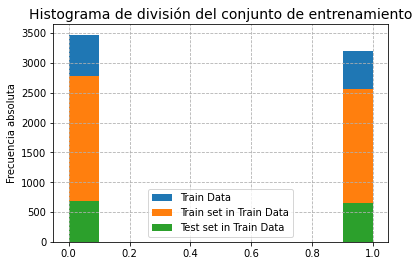

jazz and blues: 0 
soul and reggae: 1


In [20]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train, y_train, test_size = 0.2, random_state = 0)

fig = plt.figure()
y_train.hist(label='Train Data')
y_train1.hist(label='Train set in Train Data')
y_test1.hist(label='Test set in Train Data')
plt.legend()
plt.grid(linestyle='--',b=True, which='major')
plt.ylabel('Frecuencia absoluta')
plt.title('Histograma de división del conjunto de entrenamiento', fontsize=14)
plt.show()
print('jazz and blues: 0 \nsoul and reggae: 1')

## Red neural con una capa escondida

Inicialmente se evalua el perceptrón multicapa con una sola capa escondida. Entre los muchos parámetros que habría que definir para obtener una solución óptima, en este caso se definirá cual es el número de neuronas apropiado para obtener los mejores resultados de clasificación con el modelo seleccionado. Adicionalmente se evaluarán diferentes funciones de evaluación, tasas de aprendizaje y algoritmos para el entrenamiento de las redes. Este proceso de selección del número de neuras con la mejor función de activación, tasa de aprendizaje y algoritmo es presentado a continuación. Este mismo proceso será realizado para todas los perceptrones multinivel evaluados en este notebook.

Cabe resaltar que en este estudio no se tuvo en cuenta el algoritmo ```lbfgs```, el cual es un optimizador de la familia de los métodos de quasi-Newton, puesto que en muchas ocasiones para los casos estudiados necesitaba por encima de las 5000 iteraciones, por lo que requería un trabajo computacional bastante amplio. De los casos análizados en este estudio, se pudo notar que no proveía mejor precisión que los métodos ```sdg``` y ```adam```.  El método ```lbfgs``` lo recomiendan usar cuando se usan conjuntos de datos pequeños, típicamente por debajo de la escala de miles, es decir, cientos de datos típicamente.

Adicionalmente, se encuentra que un valor adecuado para el número máximo de iteraciones es 1000, puesto que con este valor se obtiene la convergencia de los algoritmos implementados.

Es importante mencionar que se está seleccionando como máximo 200 neuronas y sólo se están evalando 5 valores, también por tratar de reducir el tiempo de cómputo.

In [27]:
activacion = ['identity', 'logistic', 'tanh', 'relu'] #todas las posibles funciones de activación
tasas_aprendizaje = ['constant', 'invscaling', 'adaptive'] #todas las posibles tasas de aprendizaje
algoritmo = ['sgd', 'adam'] #los posibles algoritmos
n = 200
step = 40
top_5 = []
u=0
for i in range(2, n, step):
  for j in activacion:
    for k in tasas_aprendizaje:
      for l in algoritmo:
        MLP = MLPClassifier(hidden_layer_sizes=(i,),activation=j, learning_rate=k, solver=l,max_iter=1200)        
        clf = MLP.fit(x_train1, y_train1)
        score =clf.score(x_test1, y_test1)
        celda = [score, i, j, k, l]
        top_5.append(celda)  

A continuación se presenta la tabla con los resultados para el mejores score resultante en la validación de las redes en la capa escondida.

In [28]:
resul1 = pd.DataFrame(data=top_5, columns=['score','N', 'Función de Activación', 'Tasa de aprendizaje', 'Algoritmo'])
resul1 = resul1.sort_values(by=['score'], ascending=False)
resul1.head()

,score,N,Función de Activación,Tasa de aprendizaje,Algoritmo
117,0.866018,162,relu,invscaling,adam
119,0.857036,162,relu,adaptive,adam
71,0.856287,82,relu,adaptive,adam
47,0.855539,42,relu,adaptive,adam
43,0.854790,42,relu,constant,adam


Para una mejor visualización del comportamiento de cada uno de los parámetros estudiados, se presenta la siguiente gráfica que resume los resultados obtenidos para el caso en el que se usa el algoritmo "sgd" y el algoritmo "adam".

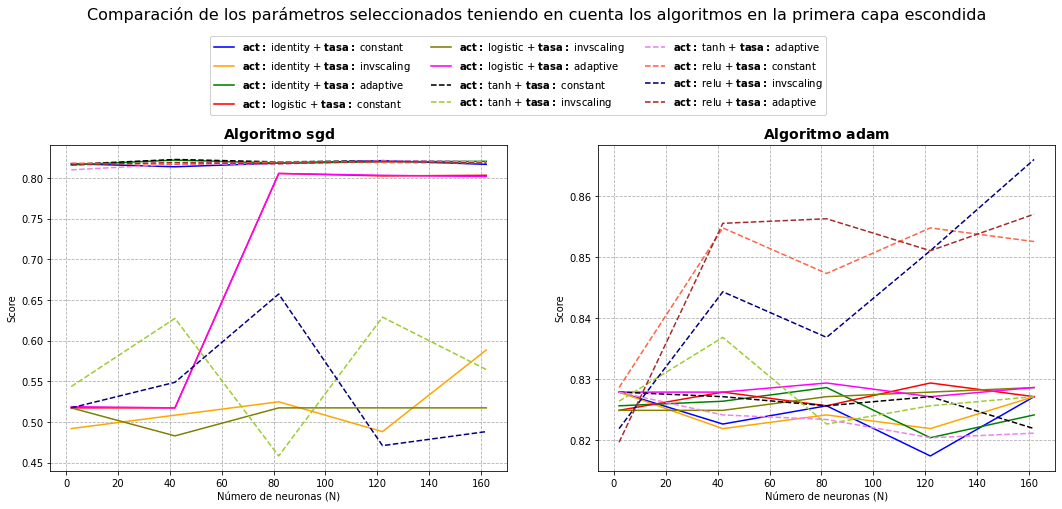

In [29]:
f = plt.figure(figsize=(18,6))
f.suptitle('Comparación de los parámetros seleccionados teniendo en cuenta los algoritmos en la primera capa escondida', y=1.2, fontsize=16)

plot_args = [{'c': 'blue', 'linestyle': '-'},
             {'c': 'orange', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '-'},
             {'c': 'olive', 'linestyle': '-'},
             {'c': 'magenta', 'linestyle': '-'},
             {'c': 'black', 'linestyle': '--'},
             {'c': 'yellowgreen', 'linestyle': '--'},
             {'c': 'violet', 'linestyle': '--'},
             {'c': 'tomato', 'linestyle': '--'},
             {'c': 'navy', 'linestyle': '--'},
             {'c': 'brown', 'linestyle': '--'}]

cont=1
args = 0
labels = []
for alg in algoritmo:
  ax = plt.subplot(1,2,cont)
  ax.set_title(r'$\bf{Algoritmo~}$'+r'$\bf{}$'.format(alg), fontsize=14)
  ax.set_ylabel('Score')
  ax.set_xlabel('Número de neuronas (N)')
  ax.grid(linestyle='--',b=True, which='major')
  for act in activacion:
    for rate in tasas_aprendizaje:
      temp = resul1.loc[(resul1['Función de Activación']==act) & (resul1['Tasa de aprendizaje']==rate) & (resul1['Algoritmo']==alg)]
      temp = temp.sort_values(by=['N'], ascending=True)
      ax.plot(temp['N'].values, temp['score'].values, **plot_args[args])
      labels.append(r'$\bf{act:}$ ' + act + ' + ' + r'$\bf{tasa:}$ ' + rate)
      if args < 11:
        args = args + 1
      else:
        args = 0

  f.legend(ax.get_lines(), labels, ncol=3, loc="lower center", bbox_to_anchor=(0.4, 0.9))
  cont = cont+1
  

Teniendo en cuenta la combinación de parámetros con el porcentaje de precisión más alto, se procede a correr el modelo de perceptrón multinivel para los datos de prueba, el modelo de entrenamiento del clasificador es presentado a continuación.

In [30]:
# Se presentan los parámetros apropiados
N = resul1.iloc[0,:]['N'] # El número de neuronas apropiado obtenido previamente
activation = resul1.iloc[0,:]['Función de Activación'] # La función de activación
learning_rate = resul1.iloc[0,:]['Tasa de aprendizaje'] # Tasa de aprendizaje
algor = resul1.iloc[0,:]['Algoritmo'] # Algoritmo seleccionado

MLP_1L = MLPClassifier(hidden_layer_sizes=(N,),activation=activation, learning_rate=learning_rate, solver=algor,max_iter=1000)
Hidden_1L = MLP_1L.fit(x_train, y_train)

La precisión del modelo seleccionado es evaluada en la siguiente entrada de código.

In [31]:
result_1L = Hidden_1L.score(x_test, y_test)
print('El modelo tiene una precisión del {:.2f}%'.format(result_1L*100))

El modelo tiene una precisión del 85.27%


Para complementar la validación del modelo, se presenta la matriz de confusión, donde se puede detallar el porcentaje normalizado de los aciertos y desaciertos del modelo para cada una de las variables a clasificar. En este caso la diagonal corresponde al porcentaje normalizado del acierto de la predicción, mientras que los elementos fuera de la diagonal representan el porcentaje de desacierto para cada variable.

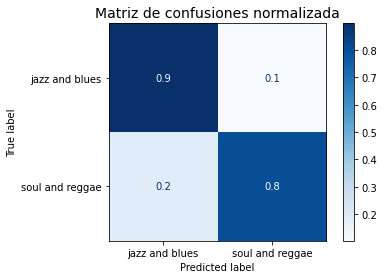

In [32]:
class_names = ['jazz and blues','soul and reggae']
plot_confusion_matrix(Hidden_1L, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize = 'true')
plt.title('Matriz de confusiones normalizada', fontsize = 14)
plt.show()

## Red neural con 2 capas escondidas

En este caso, con el fin de reducir el proceso computacional, se asumirá que el conjunto de parámetros óptimo seleccionado para el caso de una sola capa escondida, corresponderán a los parámetros de la primera capa escondida de este caso en particular. Es posible que esto no sea el mejor modelo, sin embargo, implementarlo tomaría mucho tiempo y recurso computacional, con el fin de ahorrar este tiempo, se optó por tener en cuenta la presunción previamente mencionada.



In [33]:
mejor_1capa = resul1.iloc[0]['N']
n = 200
step = 40
top_5 = []
u=0
for i in range(2, n, step):
  for j in activacion:
    for k in tasas_aprendizaje:
      for l in algoritmo:
        MLP = MLPClassifier(hidden_layer_sizes=(mejor_1capa,i,),activation=j, learning_rate=k, solver=l,max_iter=1200)        
        clf = MLP.fit(x_train1, y_train1)
        score =clf.score(x_test1, y_test1)
        celda = [score, i, j, k, l]
        top_5.append(celda)

A continuación se presenta la tabla con los resultados para el mejores score resultante en la validación de las redes de la segunda capa escondida.

In [34]:
resul2 = pd.DataFrame(data=top_5, columns=['score','N', 'Función de Activación', 'Tasa de aprendizaje', 'Algoritmo'])
resul2 = resul2.sort_values(by=['score'], ascending=False)
resul2.head()

,score,N,Función de Activación,Tasa de aprendizaje,Algoritmo
119,0.868263,162,relu,adaptive,adam
45,0.866766,42,relu,invscaling,adam
21,0.861527,2,relu,invscaling,adam
117,0.860778,162,relu,invscaling,adam
115,0.858533,162,relu,constant,adam


Para una mejor visualización del comportamiento de cada uno de los parámetros estudiados, se presenta la siguiente gráfica que resume los resultados obtenidos para el caso en el que se usa el algoritmo "sgd" y el algoritmo "adam".

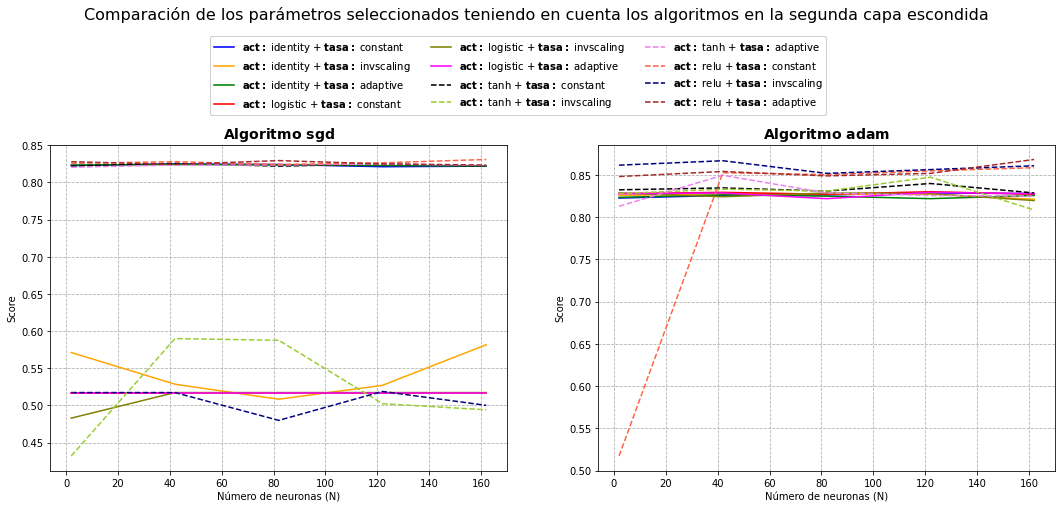

In [35]:
f = plt.figure(figsize=(18,6))
f.suptitle('Comparación de los parámetros seleccionados teniendo en cuenta los algoritmos en la segunda capa escondida', y=1.2, fontsize=16)

plot_args = [{'c': 'blue', 'linestyle': '-'},
             {'c': 'orange', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '-'},
             {'c': 'olive', 'linestyle': '-'},
             {'c': 'magenta', 'linestyle': '-'},
             {'c': 'black', 'linestyle': '--'},
             {'c': 'yellowgreen', 'linestyle': '--'},
             {'c': 'violet', 'linestyle': '--'},
             {'c': 'tomato', 'linestyle': '--'},
             {'c': 'navy', 'linestyle': '--'},
             {'c': 'brown', 'linestyle': '--'}]

cont=1
args = 0
labels = []
for alg in algoritmo:
  ax = plt.subplot(1,2,cont)
  ax.set_title(r'$\bf{Algoritmo~}$'+r'$\bf{}$'.format(alg), fontsize=14)
  ax.set_ylabel('Score')
  ax.set_xlabel('Número de neuronas (N)')
  ax.grid(linestyle='--',b=True, which='major')
  for act in activacion:
    for rate in tasas_aprendizaje:
      temp = resul2.loc[(resul2['Función de Activación']==act) & (resul2['Tasa de aprendizaje']==rate) & (resul2['Algoritmo']==alg)]
      temp = temp.sort_values(by=['N'], ascending=True)
      ax.plot(temp['N'].values, temp['score'].values, **plot_args[args])
      labels.append(r'$\bf{act:}$ ' + act + ' + ' + r'$\bf{tasa:}$ ' + rate)
      if args < 11:
        args = args + 1
      else:
        args = 0

  f.legend(ax.get_lines(), labels, ncol=3, loc="lower center", bbox_to_anchor=(0.4, 0.9))
  cont = cont+1

Teniendo en cuenta la combinación de parámetros con el porcentaje de precisión más alto, se procede a correr el modelo de perceptrón multinivel para los datos de prueba, el modelo de entrenamiento del clasificador es presentado a continuación.

In [36]:
# Se presentan los parámetros apropiados
N2 = resul2.iloc[0,:]['N'] # El número de neuronas apropiado obtenido previamente
activation = resul2.iloc[0,:]['Función de Activación'] # La función de activación
learning_rate = resul2.iloc[0,:]['Tasa de aprendizaje'] # Tasa de aprendizaje
algor = resul2.iloc[0,:]['Algoritmo'] # Algoritmo seleccionado

MLP_2L = MLPClassifier(hidden_layer_sizes=(N,N2,),activation=activation, learning_rate=learning_rate, solver=algor,max_iter=1000)
Hidden_2L = MLP_2L.fit(x_train, y_train)

La precisión del modelo seleccionado es evaluada en la siguiente entrada de código.

In [37]:
result_2L = Hidden_2L.score(x_test, y_test)
print('El modelo con dos capas tiene una precisión del {:.2f}%'.format(result_2L*100))

El modelo con dos capas tiene una precisión del 84.97%


Para complementar la validación del modelo, se presenta la matriz de confusión, donde se puede detallar el porcentaje normalizado de los aciertos y desaciertos del modelo para cada una de las variables a clasificar. En este caso la diagonal corresponde al porcentaje normalizado del acierto de la predicción, mientras que los elementos fuera de la diagonal representan el porcentaje de desacierto para cada variable.

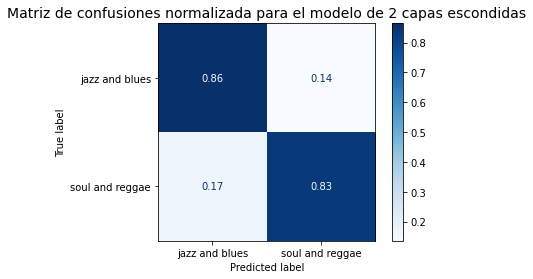

In [38]:
class_names = ['jazz and blues','soul and reggae']
plot_confusion_matrix(Hidden_2L, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize = 'true')
plt.title('Matriz de confusiones normalizada para el modelo de 2 capas escondidas', fontsize = 14)
plt.show()

## Red neural con 3 capas escondidas

En este caso, al igual que el caso anterior, se asumirá que la segunda capa tiene el mismo número de neuronas encontrado en el caso anterior. Esto se hace nuevamente con el fin de reducir el trabajo computacional, y se recalca que posiblemente esta no es el número de neuronas óptimo para este modelo. 



In [39]:
mejor_2capa = resul2.iloc[0]['N']
n = 200
step = 40
top_5 = []
u=0
for i in range(2, n, step):
  for j in activacion:
    for k in tasas_aprendizaje:
      for l in algoritmo:
        MLP = MLPClassifier(hidden_layer_sizes=(mejor_1capa,mejor_2capa,i,),activation=j, learning_rate=k, solver=l,max_iter=1200)        
        clf = MLP.fit(x_train1, y_train1)
        score =clf.score(x_test1, y_test1)
        celda = [score, i, j, k, l]
        top_5.append(celda)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


A continuación se presenta la tabla con los resultados para el mejores score resultante en la validación de las redes de la tercera capa escondida.

In [40]:
resul3 = pd.DataFrame(data=top_5, columns=['score','N', 'Función de Activación', 'Tasa de aprendizaje', 'Algoritmo'])
resul3 = resul3.sort_values(by=['score'], ascending=False)
resul3.head()

,score,N,Función de Activación,Tasa de aprendizaje,Algoritmo
117,0.866018,162,relu,invscaling,adam
41,0.854790,42,tanh,adaptive,adam
119,0.854042,162,relu,adaptive,adam
69,0.854042,82,relu,invscaling,adam
23,0.854042,2,relu,adaptive,adam


Para una mejor visualización del comportamiento de cada uno de los parámetros estudiados, se presenta la siguiente gráfica que resume los resultados obtenidos para el caso en el que se usa el algoritmo "sgd" y el algoritmo "adam".

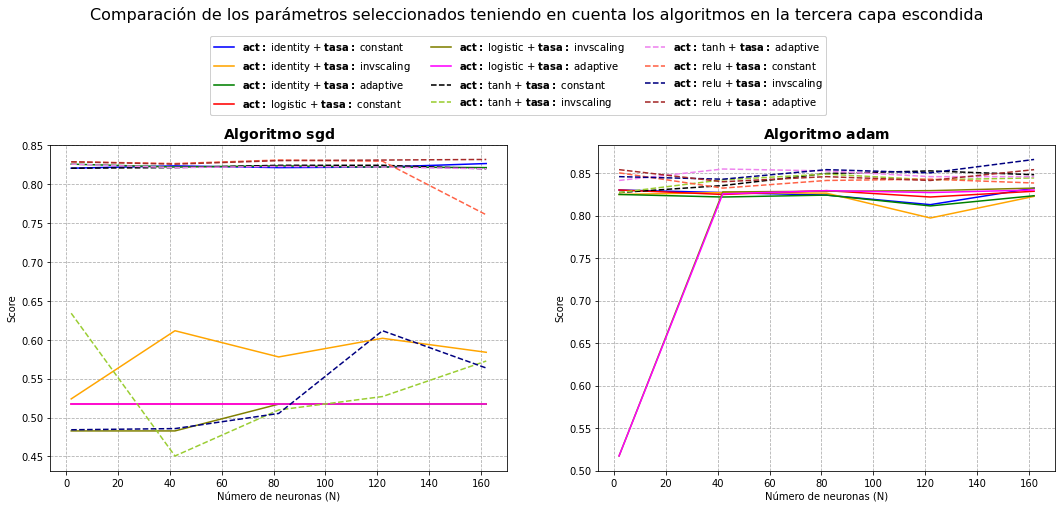

In [41]:
f = plt.figure(figsize=(18,6))
f.suptitle('Comparación de los parámetros seleccionados teniendo en cuenta los algoritmos en la tercera capa escondida', y=1.2, fontsize=16)

plot_args = [{'c': 'blue', 'linestyle': '-'},
             {'c': 'orange', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '-'},
             {'c': 'olive', 'linestyle': '-'},
             {'c': 'magenta', 'linestyle': '-'},
             {'c': 'black', 'linestyle': '--'},
             {'c': 'yellowgreen', 'linestyle': '--'},
             {'c': 'violet', 'linestyle': '--'},
             {'c': 'tomato', 'linestyle': '--'},
             {'c': 'navy', 'linestyle': '--'},
             {'c': 'brown', 'linestyle': '--'}]

cont=1
args = 0
labels = []
for alg in algoritmo:
  ax = plt.subplot(1,2,cont)
  ax.set_title(r'$\bf{Algoritmo~}$'+r'$\bf{}$'.format(alg), fontsize=14)
  ax.set_ylabel('Score')
  ax.set_xlabel('Número de neuronas (N)')
  ax.grid(linestyle='--',b=True, which='major')
  for act in activacion:
    for rate in tasas_aprendizaje:
      temp = resul3.loc[(resul3['Función de Activación']==act) & (resul3['Tasa de aprendizaje']==rate) & (resul3['Algoritmo']==alg)]
      temp = temp.sort_values(by=['N'], ascending=True)
      ax.plot(temp['N'].values, temp['score'].values, **plot_args[args])
      labels.append(r'$\bf{act:}$ ' + act + ' + ' + r'$\bf{tasa:}$ ' + rate)
      if args < 11:
        args = args + 1
      else:
        args = 0

  f.legend(ax.get_lines(), labels, ncol=3, loc="lower center", bbox_to_anchor=(0.4, 0.9))
  cont = cont+1

Teniendo en cuenta la combinación de parámetros con el porcentaje de precisión más alto, se procede a correr el modelo de perceptrón multinivel para los datos de prueba, el modelo de entrenamiento del clasificador es presentado a continuación.

In [42]:
# Se presentan los parámetros apropiados
N3 = resul3.iloc[0,:]['N'] # El número de neuronas apropiado obtenido previamente
activation = resul3.iloc[0,:]['Función de Activación'] # La función de activación
learning_rate = resul3.iloc[0,:]['Tasa de aprendizaje'] # Tasa de aprendizaje
algor = resul3.iloc[0,:]['Algoritmo'] # Algoritmo seleccionado

MLP_3L = MLPClassifier(hidden_layer_sizes=(N,N2,N3,),activation=activation, learning_rate=learning_rate, solver=algor,max_iter=1000)
Hidden_3L = MLP_3L.fit(x_train, y_train)

La precisión del modelo seleccionado es evaluada en la siguiente entrada de código.

In [43]:
result_3L = Hidden_3L.score(x_test, y_test)
print('El modelo con dos capas tiene una precisión del {:.2f}%'.format(result_3L*100))

El modelo con dos capas tiene una precisión del 84.97%


Para complementar la validación del modelo, se presenta la matriz de confusión, donde se puede detallar el porcentaje normalizado de los aciertos y desaciertos del modelo para cada una de las variables a clasificar. En este caso la diagonal corresponde al porcentaje normalizado del acierto de la predicción, mientras que los elementos fuera de la diagonal representan el porcentaje de desacierto para cada variable.

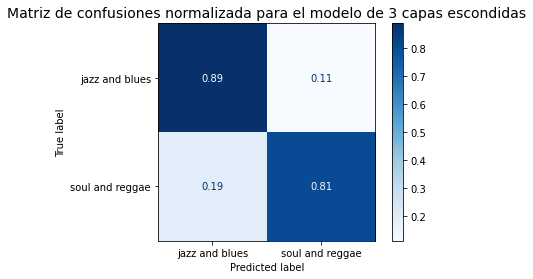

In [44]:
#y_pred = Hidden_1L.predict(x_test)
class_names = ['jazz and blues','soul and reggae']
plot_confusion_matrix(Hidden_3L, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues, normalize = 'true')
plt.title('Matriz de confusiones normalizada para el modelo de 3 capas escondidas', fontsize = 14)
plt.show()

## Conclusiones

En la siguiente tabla se resume el porcentaje de precisión de cada modelo implementado.

In [45]:
print('Modelo 1: MLP con 1 capa escondida \nModelo 2: MLP con 2 capas escondidas \nModelo 3: MLP con 3 capas escondidas \n')
medida =['Score']
results = {'Modelo 1': result_1L,
           'Modelo 2': result_2L,
           'Modelo 3': result_3L}
pd.DataFrame(results,medida,columns=['Modelo 1','Modelo 2', 'Modelo 3'])



Modelo 1: MLP con 1 capa escondida 
Modelo 2: MLP con 2 capas escondidas 
Modelo 3: MLP con 3 capas escondidas 



,Modelo 1,Modelo 2,Modelo 3
Score,0.852695,0.849701,0.849701


Se concluye así que el mejor modelo es el modelo con # capas escondidas. Por otra parte, cabe mencionar que el tiempo aproximado de ejecución de este notebook es de 132 minutos, aproximadamente.